In [1]:
import numpy as np
import xarray as xr
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
import matplotlib.pyplot as plt
%matplotlib inline

Below we will create a synthetic temperature profile with decreasing temperature at depth, with unevenly spaced depth intervals (commonly found in hydrographic data).

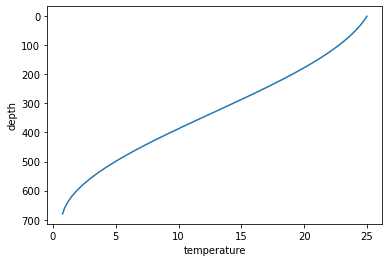

In [2]:
# create a synthetic ocean temperature profile with uneven spacing in depth
z = np.hstack([np.arange(1,10, 1), np.arange(10,200, 10), np.arange(200,700, 20)])
# Create synthetic temperature profile with maximum temperature gradient at mid depth (e.g. the thermocline)
temp = ((np.cos(np.pi*z/700) + 1) + np.exp(-z/350) / 2) * 10

# Convert to xarray.Dataset
ds = xr.DataArray(temp, dims=['depth'], coords={'depth':z}).to_dataset(name='temperature')

ds.temperature.plot(y='depth', yincrease=False)

In [3]:
z


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  20,  30,  40,
        50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
       420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660,
       680])

### Infer the cell boundaries using xgcm.autogenerate
generate_grid_ds can infer the missing cell positions based on the given position (defaults to cell center) and the axis, which is defined by passing a dictionary with the physical axis as key and the dataset dimensions belonging to that axis as values.

In [4]:
# Generate 'full' dataset, which includes additional coordinate `depth_left` and appropriate attributes.
ds_full = generate_grid_ds(ds, {'Z':'depth'})
print(ds_full)
print(ds.depth.data)
print(ds_full.depth_left.data)

<xarray.Dataset>
Dimensions:      (depth: 53, depth_left: 53)
Coordinates:
  * depth        (depth) int64 1 2 3 4 5 6 7 8 ... 560 580 600 620 640 660 680
  * depth_left   (depth_left) float64 0.5 1.5 2.5 3.5 ... 630.0 650.0 670.0
Data variables:
    temperature  (depth) float64 24.99 24.97 24.96 24.94 ... 1.164 0.9193 0.7567
[  1   2   3   4   5   6   7   8   9  10  20  30  40  50  60  70  80  90
 100 110 120 130 140 150 160 170 180 190 200 220 240 260 280 300 320 340
 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680]
[5.00e-01 1.50e+00 2.50e+00 3.50e+00 4.50e+00 5.50e+00 6.50e+00 7.50e+00
 8.50e+00 9.50e+00 1.50e+01 2.50e+01 3.50e+01 4.50e+01 5.50e+01 6.50e+01
 7.50e+01 8.50e+01 9.50e+01 1.05e+02 1.15e+02 1.25e+02 1.35e+02 1.45e+02
 1.55e+02 1.65e+02 1.75e+02 1.85e+02 1.95e+02 2.10e+02 2.30e+02 2.50e+02
 2.70e+02 2.90e+02 3.10e+02 3.30e+02 3.50e+02 3.70e+02 3.90e+02 4.10e+02
 4.30e+02 4.50e+02 4.70e+02 4.90e+02 5.10e+02 5.30e+02 5.50e+02 5.70e+02
 5.90e+02 6.10e+02 

We see now that a new dimension depth_left was created, with cell boundaries shifted towards the surface

The default behaviour of generate_grid_ds is to extrapolate the grid position to the ‘left’ (e.g. towards the surface for a depth profile), assuming that the spacing in the two cells closest to the boundary (here: the first and second cell) is equal. Particular geometries might require adjustments of the boundary treatment, by specifying e.g. pad=0 to ensure the topmost cell boundary is located at the sea surface.

Finally we can create the xgcm.Grid object like we would from model output (see for example here)

In [5]:
# Create grid object
grid = Grid(ds_full, periodic=False)
print(grid)

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


### Calculate vertical gradient
Now we have all the tools we need to calculate the vertical gradient just like with numerical model output

In [6]:
# Calculate vertical distances located on the cellboundary
ds_full.coords['dzc'] = grid.diff(ds_full.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds_full.coords['dzt'] = grid.diff(ds_full.depth_left, 'Z', boundary='extrapolate')

<xarray.DataArray (depth_left: 53)>
array([        nan, -0.01452675, -0.01468758, -0.01484852, -0.01500955,
       -0.01517068, -0.01533191, -0.01549322, -0.01565462, -0.01581609,
       -0.01670564, -0.01832588, -0.01994686, -0.02156426, -0.02317378,
       -0.02477119, -0.02635229, -0.02791296, -0.02944913, -0.03095681,
       -0.03243211, -0.0338712 , -0.03527037, -0.03662601, -0.0379346 ,
       -0.03919276, -0.04039723, -0.04154487, -0.04263268, -0.04413764,
       -0.04591988, -0.04741622, -0.04860995, -0.04948706, -0.05003634,
       -0.05024945, -0.05012097, -0.04964842, -0.04883232, -0.04767612,
       -0.04618617, -0.04437168, -0.04224465, -0.0398197 , -0.03711403,
       -0.0341472 , -0.030941  , -0.02751928, -0.02390771, -0.02013362,
       -0.01622573, -0.01221393, -0.00812903])
Coordinates:
  * depth_left  (depth_left) float64 0.5 1.5 2.5 3.5 ... 610.0 630.0 650.0 670.0
    dzc         (depth_left) int64 1 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20 20


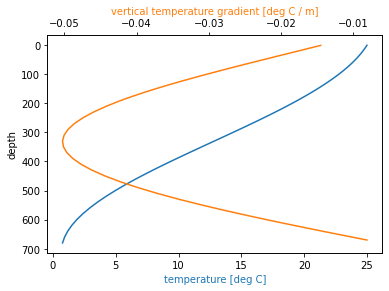

In [7]:
# note that the temperature gradient is located on the `depth_left` dimension,
# but no temperature information is available, to infer the gradient in the topmost grid cell.
# The following will pad with nan towards the surface. Alternatively the values could be padded with
# with a particular value or linearly extrapolated.

dtemp_dz = grid.diff(ds.temperature, 'Z', boundary='fill', fill_value=np.nan) / ds_full.dzc
print(dtemp_dz)


fig, ax1 = plt.subplots()
ax1.invert_yaxis()
ax2 = ax1.twiny()

ds.temperature.plot(ax=ax1, y='depth', color='C0')
ax1.set_xlabel('temperature [deg C]', color='C0')

dtemp_dz.plot(ax=ax2, y='depth_left', color='C1')
ax2.set_xlabel('vertical temperature gradient [deg C / m]', color='C1');

## Depth weighted average
Another common operation for many climate datasets is a weighted mean along an unevenly spaced dimension. Using the grid spacing for the tracer cells earlier this becomes trivial.

In [8]:
mean_temp = ds_full.temperature.mean('depth')
mean_temp_weighted = (ds_full.temperature * ds_full.dzt).sum('depth') / ds_full.dzt.sum('depth')

print(mean_temp.data)
print(mean_temp_weighted.data)

16.271481181388438
12.320585088179214


## Periodic 2D example
Below we will show how to apply these methods similarly to a global surface wind field, which is periodic in the longitudinal (‘x’) direction. The dataset is stored in a zenodo archive.

In [9]:
# download the data
import urllib.request
import shutil

url = 'https://zenodo.org/record/4421428/files/'
file_name = 'uvwnd.10m.gauss.2018.nc'
with urllib.request.urlopen(url + file_name) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# open the data
ds = xr.open_dataset(file_name)
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 71)
Coordinates:
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-03-12
Dimensions without coordinates: nbnds
Data variables:
    uwnd       (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) float64 ...
    vwnd       (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC reanalysis (2014)
    history:        created 2017/12 by Hoop (netCDF2.3)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1

In [10]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
ds_full

<xarray.Dataset>
Dimensions:    (lat: 94, lat_left: 94, lon: 192, lon_left: 192, nbnds: 2, time: 71)
Coordinates:
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-03-12
  * lon_left   (lon_left) float32 -0.9375 0.9375 2.812 ... 353.4 355.3 357.2
  * lat_left   (lat_left) float32 89.49 87.6 85.7 83.8 ... -83.8 -85.7 -87.6
Dimensions without coordinates: nbnds
Data variables:
    uwnd       (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) float64 1.911e+06 1.911e+06 ... 1.913e+06 1.913e+06
    vwnd       (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC reanalysis (2014)
    history:        created 2017/12 by Hoop (netCDF2.3)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1

As in the depth profile the longitude and latitude values are extended to the left when the defaults are used. However, since the latitude is not periodic we can specify the position to extend to as outer (more details here). This will extend the latitudinal positions both to the left and right, avoiding missing values later on.



In [11]:
grid = Grid(ds_full, periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center

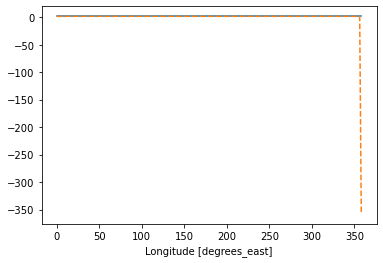

In [12]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)

dlonc.plot()
dlonc_wo_discontinuity.plot(linestyle='--')

Without adding the boundary_discontinuity input, the last cell distance is calculated incorectly.

The values we just calculated are actually not cell distances, but instead differences in longitude and latitude (in degrees). In order to calculate operators like the gradient dlon and dlat have to be converted into approximate cartesian distances on a globe.

In [13]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)

Based on the distances we can estimate the area of each grid cell and compute the area-weighted meridional average temperature

In [14]:
# area-weighted meridional average temperature
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc

## Compute zonal gradient of the surface wind field
Now that all needed grid metrics are available, we can compute the zonal temperature gradient similar as above.

In [15]:
du_dx = grid.diff(ds_full.uwnd, 'X') / ds_full.dxg
du_dx

<xarray.DataArray (time: 71, lat: 94, lon_left: 192)>
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -1.1802297e-05,  0.0000000e+00],
        [ 0.0000000e+00,  5.1437846e-06,  0.0000000e+00, ...,
          0.0000000e+00,  5.1437846e-06,  0.0000000e+00],
        [-9.8517148e-06, -1.3135620e-05, -9.8517148e-06, ...,
         -6.5678100e-06, -6.5678100e-06, -9.8517148e-06],
        ...,
        [ 6.5678100e-06,  6.5678100e-06,  6.5678100e-06, ...,
          0.0000000e+00,  3.2839050e-06,  6.5678100e-06],
        [ 1.5431353e-05,  2.0575138e-05,  1.5431353e-05, ...,
          1.5431353e-05,  1.5431353e-05,  1.5431353e-05],
        [ 4.7209189e-05,  3.5406894e-05,  4.7209189e-05, ...,
          4.7209189e-05,  3.5406894e-05,  4.7209189e-05]],

       [[ 0.0000000e+00, -1.1802297e-05,  0.0000000e+00, ...,
          0.0000000e+00, -2.3604594e-05,  0.0000000e+00],
        [-5.1437846e-06, -5.1437846e-06, -5.1437846e-06, ...,
         -5.1437846e-06, -5.1437846e-06,  0.0000000e+00],
        [-6.5678100e-06, -9.8517148e-06, -1.3135620e-05, ...,
         -6.5678100e-06, -6.5678100e-06, -1.3135620e-05],
...
        [ 1.3135620e-05,  1.6419526e-05,  9.8517148e-06, ...,
          2.2987335e-05,  1.6419526e-05,  1.9703430e-05],
        [ 2.5718922e-05,  2.0575138e-05,  1.5431353e-05, ...,
          2.5718922e-05,  2.0575138e-05,  2.0575138e-05],
        [ 3.5406894e-05,  3.5406894e-05,  3.5406894e-05, ...,
          4.7209189e-05,  4.7209189e-05,  3.5406894e-05]],

       [[ 0.0000000e+00,  1.1802297e-05,  0.0000000e+00, ...,
          1.1802297e-05,  1.1802297e-05,  1.1802297e-05],
        [-5.1437846e-06, -5.1437846e-06, -1.0287569e-05, ...,
         -1.0287569e-05, -5.1437846e-06, -5.1437846e-06],
        [-1.3135620e-05, -1.3135620e-05, -9.8517148e-06, ...,
         -1.3135620e-05, -1.3135620e-05, -1.6419526e-05],
        ...,
        [ 1.3135620e-05,  1.3135620e-05,  9.8517148e-06, ...,
          1.9703430e-05,  1.9703430e-05,  1.9703430e-05],
        [ 1.5431353e-05,  2.0575138e-05,  1.5431353e-05, ...,
          2.0575138e-05,  2.5718922e-05,  2.0575138e-05],
        [ 4.7209189e-05,  4.7209189e-05,  4.7209189e-05, ...,
          4.7209189e-05,  3.5406894e-05,  3.5406894e-05]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-03-12
  * lat       (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon_left  (lon_left) float32 -0.9375 0.9375 2.812 ... 353.4 355.3 357.2
    dxg       (lon_left, lat) float32 5.296e+03 1.215e+04 ... 5.296e+03

The values of the gradient are correctly located on the cell boundary on the x-axis and on the cell center in the y-axis

ValueError: too many values to unpack (expected 3)

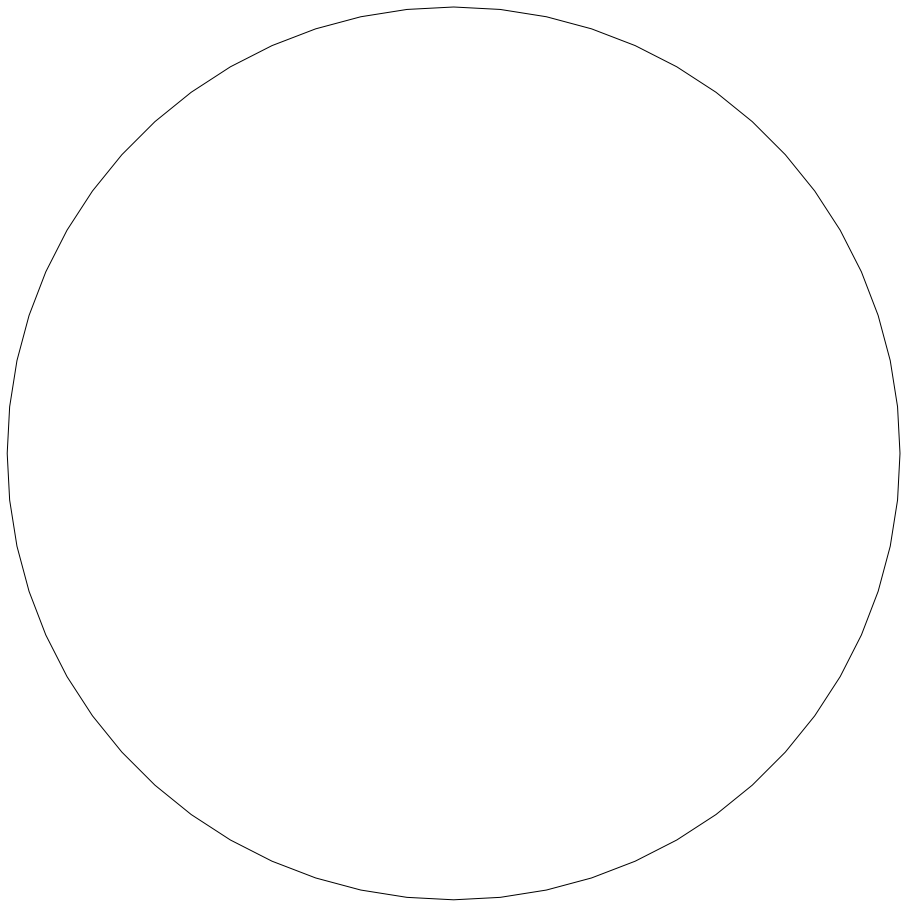

In [37]:
import cartopy.crs as ccrs

plt.figure(figsize=[16,20])

ax1 = plt.subplot(1,1,1, projection=ccrs.Orthographic(0, -30))
time = ds_full.time.isel(time=0).data
ds_full.uwnd.isel(time=0).plot(ax=ax1, transform=ccrs.PlateCarree(),robust=True)

du_dx.isel(time=0).plot(ax=ax1, transform=ccrs.PlateCarree(), robust=True)
ax1.coastlines('50m')
ax1.set_global()



In [ ]:
    plt.figure(figsize=(8, 10))

    x, y, u, v, vector_crs = sample_data(shape=(50, 50))
    ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
    ax1.coastlines('50m')
    ax1.set_extent([-45, 55, 20, 80], ccrs.PlateCarree())
    ax1.quiver(x, y, u, v, transform=vector_crs)

    ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
    plt.title('The same vector field regridded')
    ax2.coastlines('50m')
    ax2.set_extent([-45, 55, 20, 80], ccrs.PlateCarree())
    ax2.quiver(x, y, u, v, transform=vector_crs, regrid_shape=20)


In [47]:
du_dx.lon_left

<xarray.DataArray 'lon_left' (lon_left: 192)>
array([ -0.9375,   0.9375,   2.8125,   4.6875,   6.5625,   8.4375,  10.3125,
        12.1875,  14.0625,  15.9375,  17.8125,  19.6875,  21.5625,  23.4375,
        25.3125,  27.1875,  29.0625,  30.9375,  32.8125,  34.6875,  36.5625,
        38.4375,  40.3125,  42.1875,  44.0625,  45.9375,  47.8125,  49.6875,
        51.5625,  53.4375,  55.3125,  57.1875,  59.0625,  60.9375,  62.8125,
        64.6875,  66.5625,  68.4375,  70.3125,  72.1875,  74.0625,  75.9375,
        77.8125,  79.6875,  81.5625,  83.4375,  85.3125,  87.1875,  89.0625,
        90.9375,  92.8125,  94.6875,  96.5625,  98.4375, 100.3125, 102.1875,
       104.0625, 105.9375, 107.8125, 109.6875, 111.5625, 113.4375, 115.3125,
       117.1875, 119.0625, 120.9375, 122.8125, 124.6875, 126.5625, 128.4375,
       130.3125, 132.1875, 134.0625, 135.9375, 137.8125, 139.6875, 141.5625,
       143.4375, 145.3125, 147.1875, 149.0625, 150.9375, 152.8125, 154.6875,
       156.5625, 158.4375, 160.3125, 162.1875, 164.0625, 165.9375, 167.8125,
       169.6875, 171.5625, 173.4375, 175.3125, 177.1875, 179.0625, 180.9375,
       182.8125, 184.6875, 186.5625, 188.4375, 190.3125, 192.1875, 194.0625,
       195.9375, 197.8125, 199.6875, 201.5625, 203.4375, 205.3125, 207.1875,
       209.0625, 210.9375, 212.8125, 214.6875, 216.5625, 218.4375, 220.3125,
       222.1875, 224.0625, 225.9375, 227.8125, 229.6875, 231.5625, 233.4375,
       235.3125, 237.1875, 239.0625, 240.9375, 242.8125, 244.6875, 246.5625,
       248.4375, 250.3125, 252.1875, 254.0625, 255.9375, 257.8125, 259.6875,
       261.5625, 263.4375, 265.3125, 267.1875, 269.0625, 270.9375, 272.8125,
       274.6875, 276.5625, 278.4375, 280.3125, 282.1875, 284.0625, 285.9375,
       287.8125, 289.6875, 291.5625, 293.4375, 295.3125, 297.1875, 299.0625,
       300.9375, 302.8125, 304.6875, 306.5625, 308.4375, 310.3125, 312.1875,
       314.0625, 315.9375, 317.8125, 319.6875, 321.5625, 323.4375, 325.3125,
       327.1875, 329.0625, 330.9375, 332.8125, 334.6875, 336.5625, 338.4375,
       340.3125, 342.1875, 344.0625, 345.9375, 347.8125, 349.6875, 351.5625,
       353.4375, 355.3125, 357.1875], dtype=float32)
Coordinates:
  * lon_left  (lon_left) float32 -0.9375 0.9375 2.812 ... 353.4 355.3 357.2
Attributes:
    axis:               X
    c_grid_axis_shift:  -0.5

TypeError: pcolormesh() takes 1 or 3 positional arguments but 2 were given

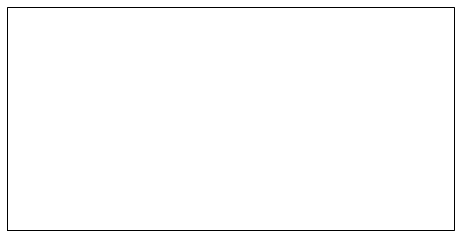

In [100]:
plt.figure(figsize=(8, 10))
ax1 = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.pcolormesh(du_test['lon_left'].values, du_test['lat'].values, du_test[0], transform=ccrs.PlateCarree())


In [86]:
du_test = du_dx.drop('dxg')

In [93]:
du_dx.shape

(71, 94, 192)

In [94]:
du_dx[0].shape

(94, 192)

In [95]:
du_dx.lat.shape

(94,)

In [96]:
du_dx.lon_left.shape

(192,)